### COMP 5328 ASSIGNMENT 2

In [3]:
import numpy as np
#import warnings
#warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold
def load_data(path):
    dataset = np.load(path)
    Xtr_val = dataset['Xtr']
    Str_val = dataset['Str']
    Xts = dataset['Xts']
    Yts = dataset['Yts']

    return Xtr_val, Str_val, Xts, Yts

Xtr_val, Str_val, Xts, Yts = load_data("FashionMNIST0.5.npz")
print(Xtr_val.shape)
print(Str_val.shape)
print(Xts.shape)
print(Yts.shape)
Xtr_val_flat = Xtr_val.reshape((Xtr_val.shape[0], -1))
Xts_flat = Xts.reshape((Xts.shape[0], -1))

(18000, 28, 28)
(18000,)
(3000, 28, 28)
(3000,)


### DecisionTree + CostSensitive On 0.5 Dataset

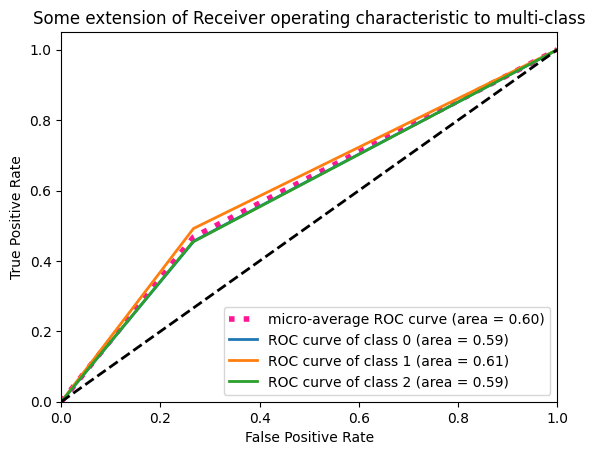

Recall: 0.4673
Precision: 0.4672
F1 Score: 0.4672
Top-1 Accuracy: 0.4673
Average cost-sensitive validation accuracy: 0.6141
Average cost-sensitive test accuracy: 0.6159


In [5]:
Xts_flat = Xts.reshape(Xts.shape[0], -1)

acc_valid_list = []
acc_test_without_T_list = []
acc_test_with_T_list = []
acc_valid_list = []
acc_test_list = []

def cost_sensitive_accuracy(y_true, y_pred, cost_matrix):

    
    cost = np.array([cost_matrix[true, pred] for true, pred in zip(y_true, y_pred)])
    total_cost = np.sum(cost)
    max_cost = np.sum(cost_matrix.min(axis=1) * len(y_true))
    return 1 - (total_cost / max_cost)

class CostSensitiveDecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(self, cost_matrix=None):
        self.cost_matrix = cost_matrix
    
    def fit(self, X, y):
     X, y = check_X_y(X, y)
     self.classes_ = np.unique(y)
    
  
     self.model_ = DecisionTreeClassifier()
     sample_weights = self.cost_matrix[y, :]
     sample_weights = np.min(sample_weights, axis=1)

     self.model_.fit(X, y, sample_weight=sample_weights)

     return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return self.model_.predict(X)
    
    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return self.model_.predict_proba(X)
    
    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

# Create the cost matrix from the transition matrix
T_FashionMNIST0_5 = np.array([
    [0.5, 0.2, 0.3],
    [0.3, 0.5, 0.2],
    [0.2, 0.3, 0.5]
])
cost_matrix = 1 / T_FashionMNIST0_5
np.fill_diagonal(cost_matrix, 0)
min_nonzero_cost = np.min(cost_matrix[cost_matrix != 0])
epsilon = 1e-5 
np.fill_diagonal(cost_matrix, min_nonzero_cost - epsilon)

# Normalize costs to avoid very large values
cost_matrix /= np.max(cost_matrix)
for i in range(10):
    # Use the flattened data for splitting
    X_train, X_valid, y_train, y_valid = train_test_split(
        Xtr_val_flat, Str_val, test_size=0.2, random_state=i
    )
    
    # Initialize the CostSensitiveDecisionTree with the cost matrix
    model = CostSensitiveDecisionTree(cost_matrix=cost_matrix)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate the model on the validation set using cost-sensitive accuracy
    y_valid_pred = model.predict(X_valid)
    acc_valid = cost_sensitive_accuracy(y_valid, y_valid_pred, cost_matrix)
    acc_valid_list.append(acc_valid)
    
    # Evaluate the model on the test set using cost-sensitive accuracy
    y_test_pred = model.predict(Xts_flat)
    acc_test = cost_sensitive_accuracy(Yts, y_test_pred, cost_matrix)
    acc_test_list.append(acc_test)

# Calculate the average cost-sensitive performance over the 10 different splits
avg_valid_accuracy = np.mean(acc_valid_list)
avg_test_accuracy = np.mean(acc_test_list)


# Binarize the output labels for ROC AUC since it's a multi-class setting
Yts_binarized = label_binarize(Yts, classes=np.unique(Yts))
y_test_pred_proba = model.predict_proba(Xts_flat)  # Make sure your model can output probabilities

# Compute the ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(Yts_binarized.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(Yts_binarized[:, i], y_test_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Yts_binarized.ravel(), y_test_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotting ROC curves
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

for i in range(Yts_binarized.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

recall = recall_score(Yts, y_test_pred, average='macro')
precision = precision_score(Yts, y_test_pred, average='macro')
f1 = f1_score(Yts, y_test_pred, average='macro')
top1_accuracy = accuracy_score(Yts, y_test_pred) 

print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Top-1 Accuracy: {top1_accuracy:.4f}')
print(f"Average cost-sensitive validation accuracy: {avg_valid_accuracy:.4f}")
print(f"Average cost-sensitive test accuracy: {avg_test_accuracy:.4f}")

### DecisionTree + Reweighting On 0.5 Dataset

Average validation accuracy: 0.3706
Average test accuracy: 0.4728


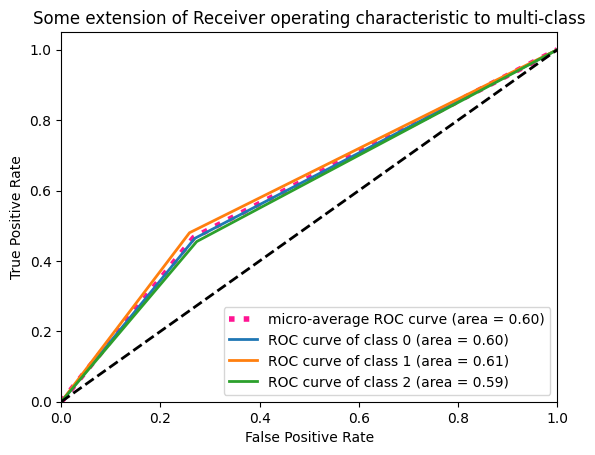

Recall: 0.4663
Precision: 0.4664
F1 Score: 0.4663
Top-1 Accuracy: 0.4663


In [6]:
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_X_y, check_array

def load_data(path):
    dataset = np.load(path, allow_pickle=True)
    return dataset['Xtr'], dataset['Str'], dataset['Xts'], dataset['Yts']

# Reweighting classifier
class ReweightingDecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(self, transition_matrix=None):
        self.transition_matrix = transition_matrix
        self.model_ = DecisionTreeClassifier()

    def fit(self, X, y, sample_weight=None):
        X, y = check_X_y(X, y)
        self.classes_ = np.unique(y)
        # Adjust sample weights using the transition matrix if provided
        if self.transition_matrix is not None and sample_weight is not None:
            sample_weight = self.adjust_weights(y, sample_weight)
        self.model_.fit(X, y, sample_weight=sample_weight)
        return self

    def adjust_weights(self, y, sample_weight):
        # Estimate class priors based on the training data
        class_priors = np.bincount(y, minlength=self.transition_matrix.shape[0]) / float(len(y))
        # Apply transition matrix to class priors
        effective_class_priors = np.dot(self.transition_matrix.T, class_priors)
        # Adjust weights
        adjusted_weights = sample_weight / effective_class_priors[y]
        return adjusted_weights
    
    def predict_proba(self, X):
        # Check if fit had been called
        check_is_fitted(self, 'model_')  # This ensures that the model has been fitted
        # Input validation
        X = check_array(X)
        return self.model_.predict_proba(X)    


    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return self.model_.predict(X)
    
    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

# Function to calculate class weights based on class frequencies
def calculate_class_weights(y):
    class_weights = np.bincount(y)
    class_weights = 1. / class_weights
    class_weights = class_weights / np.sum(class_weights)  # Normalize to sum to 1
    return class_weights

# Load the data
Xtr_val, Str_val, Xts, Yts = load_data("FashionMNIST0.5.npz")
Xtr_val_flat = Xtr_val.reshape((Xtr_val.shape[0], -1))
Xts_flat = Xts.reshape((Xts.shape[0], -1))

# Initialize the transition matrix
T_FashionMNIST0_5 = np.array([
    [0.5, 0.2, 0.3],
    [0.3, 0.5, 0.2],
    [0.2, 0.3, 0.5]
])

# Calculate class weights based on training set
class_weights = calculate_class_weights(Str_val)

# Initialize lists to keep track of accuracies
acc_valid_list = []
acc_test_list = []

# Cross-validation loop
for i in range(10):
    # Split the data
    X_train, X_valid, y_train, y_valid = train_test_split(
        Xtr_val_flat, Str_val, test_size=0.2, random_state=i
    )
    
    # Calculate sample weights for the current split
    sample_weights = class_weights[y_train]
    
    # Initialize the ReweightingDecisionTree with the transition matrix
    model = ReweightingDecisionTree(transition_matrix=T_FashionMNIST0_5)
    
    # Train the model with sample weights
    model.fit(X_train, y_train, sample_weight=sample_weights)
    
    # Evaluate the model on the validation set
    y_valid_pred = model.predict(X_valid)
    acc_valid = accuracy_score(y_valid, y_valid_pred)
    acc_valid_list.append(acc_valid)
    
    # Evaluate the model on the test set
    y_test_pred = model.predict(Xts_flat)
    acc_test = accuracy_score(Yts, y_test_pred)
    acc_test_list.append(acc_test)

# Calculate the average accuracies over the splits
avg_valid_accuracy = np.mean(acc_valid_list)
avg_test_accuracy = np.mean(acc_test_list)

print(f"Average validation accuracy: {avg_valid_accuracy:.4f}")
print(f"Average test accuracy: {avg_test_accuracy:.4f}")

Yts_binarized = label_binarize(Yts, classes=np.unique(Yts))
y_test_pred_proba = model.predict_proba(Xts_flat)  # Make sure your model can output probabilities

# Compute the ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(Yts_binarized.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(Yts_binarized[:, i], y_test_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Yts_binarized.ravel(), y_test_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotting ROC curves
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

for i in range(Yts_binarized.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Evaluating other metrics
recall = recall_score(Yts, y_test_pred, average='macro')
precision = precision_score(Yts, y_test_pred, average='macro')
f1 = f1_score(Yts, y_test_pred, average='macro')
top1_accuracy = accuracy_score(Yts, y_test_pred)  # Top-1 Accuracy is the same as the normal accuracy

print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Top-1 Accuracy: {top1_accuracy:.4f}')



Metrics

### DecisionTree + CostSensitive On 0.6 Dataset

(18000, 28, 28)
(18000,)
(3000, 28, 28)
(3000,)


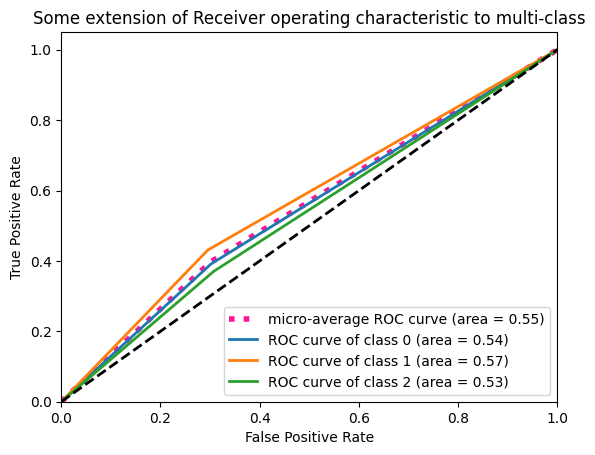

Recall: 0.3973
Precision: 0.3970
F1 Score: 0.3972
Top-1 Accuracy: 0.3973


In [7]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
Xtr_val, Str_val, Xts, Yts = load_data("FashionMNIST0.6.npz")
print(Xtr_val.shape)
print(Str_val.shape)
print(Xts.shape)
print(Yts.shape)
Xtr_val_flat = Xtr_val.reshape((Xtr_val.shape[0], -1))
Xts_flat = Xts.reshape((Xts.shape[0], -1))

Xts_flat = Xts.reshape(Xts.shape[0], -1)


f1_scores = []
recall_scores = []
precision_scores = []
roc_auc_scores = []

acc_valid_list = []
acc_test_without_T_list = []
acc_test_with_T_list = []
acc_valid_list = []
acc_test_list = []

def cost_sensitive_accuracy(y_true, y_pred, cost_matrix):
    """
    Compute cost-sensitive accuracy. Lower costs are better; 0 cost for correct predictions.
    """
    # Map the true and predicted labels to their respective cost
    cost = np.array([cost_matrix[true, pred] for true, pred in zip(y_true, y_pred)])
    # Calculate the total cost
    total_cost = np.sum(cost)
    # The lower the cost, the higher the 'accuracy' (cost of 0 would be perfect accuracy)
    max_cost = np.sum(cost_matrix.min(axis=1) * len(y_true))
    return 1 - (total_cost / max_cost)

class CostSensitiveDecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(self, cost_matrix=None):
        self.cost_matrix = cost_matrix
    
    def fit(self, X, y):
     X, y = check_X_y(X, y)
     self.classes_ = np.unique(y)
    
    # Initialize the Decision Tree model
     self.model_ = DecisionTreeClassifier()

    # Compute sample weights for each instance
     sample_weights = self.cost_matrix[y, :]

    # If the sample_weights is a 2D array, we may need to reduce it to 1D
    # This depends on how you've structured your cost matrix
    # If your cost matrix is such that the cost for the correct class is the smallest value
    # in each row, then you might do:
     sample_weights = np.min(sample_weights, axis=1)

    # Fit the model with custom sample weights
     self.model_.fit(X, y, sample_weight=sample_weights)

     return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return self.model_.predict(X)
    
    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return self.model_.predict_proba(X)
    
    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

# Create the cost matrix from the transition matrix
T_FashionMNIST0_6 = np.array([
    [0.4, 0.3, 0.3],
    [0.3, 0.4, 0.3],
    [0.3, 0.3, 0.4]
])
cost_matrix = 1 / T_FashionMNIST0_6
np.fill_diagonal(cost_matrix, 0)
min_nonzero_cost = np.min(cost_matrix[cost_matrix != 0])
epsilon = 1e-5  # A small number to ensure correct classification has the lowest cost
np.fill_diagonal(cost_matrix, min_nonzero_cost - epsilon)

# Normalize costs to avoid very large values
cost_matrix /= np.max(cost_matrix)

for i in range(10):
    # Use the flattened data for splitting
    X_train, X_valid, y_train, y_valid = train_test_split(
        Xtr_val_flat, Str_val, test_size=0.2, random_state=i
    )
    
    # Initialize the CostSensitiveDecisionTree with the cost matrix
    model = CostSensitiveDecisionTree(cost_matrix=cost_matrix)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate the model on the validation set using cost-sensitive accuracy
    y_valid_pred = model.predict(X_valid)
    acc_valid = cost_sensitive_accuracy(y_valid, y_valid_pred, cost_matrix)
    acc_valid_list.append(acc_valid)
    
    # Evaluate the model on the test set using cost-sensitive accuracy
    y_test_pred = model.predict(Xts_flat)
    acc_test = cost_sensitive_accuracy(Yts, y_test_pred, cost_matrix)
    acc_test_list.append(acc_test)

    # Calculate and store the F1 score, recall, precision, and ROC AUC
    f1_scores.append(f1_score(Yts, y_test_pred, average='weighted'))
    recall_scores.append(recall_score(Yts, y_test_pred, average='weighted'))
    precision_scores.append(precision_score(Yts, y_test_pred, average='weighted'))
    roc_auc_scores.append(roc_auc_score(Yts, model.predict_proba(Xts_flat), multi_class='ovr'))

# Calculate the average cost-sensitive performance over the 10 different splits
avg_valid_accuracy = np.mean(acc_valid_list)
avg_test_accuracy = np.mean(acc_test_list)
# Calculate the average F1 score, recall, precision, and ROC AUC
avg_f1_score = np.mean(f1_scores)
avg_recall = np.mean(recall_scores)
avg_precision = np.mean(precision_scores)
avg_roc_auc = np.mean(roc_auc_scores)

# Binarize the output labels for ROC AUC since it's a multi-class setting
Yts_binarized = label_binarize(Yts, classes=np.unique(Yts))
y_test_pred_proba = model.predict_proba(Xts_flat)  # Make sure your model can output probabilities

# Compute the ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(Yts_binarized.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(Yts_binarized[:, i], y_test_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Yts_binarized.ravel(), y_test_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotting ROC curves
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

for i in range(Yts_binarized.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Evaluating other metrics
recall = recall_score(Yts, y_test_pred, average='macro')
precision = precision_score(Yts, y_test_pred, average='macro')
f1 = f1_score(Yts, y_test_pred, average='macro')
top1_accuracy = accuracy_score(Yts, y_test_pred)  # Top-1 Accuracy is the same as the normal accuracy

print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Top-1 Accuracy: {top1_accuracy:.4f}')


### DecisionTree + Reweighting On 0.6 Dataset

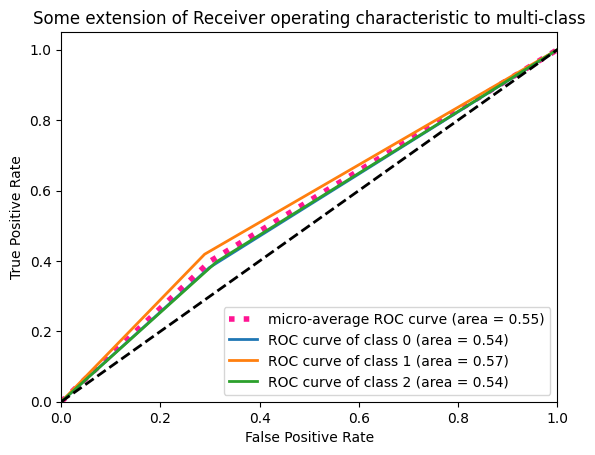

Recall: 0.3993
Precision: 0.3994
F1 Score: 0.3993
Top-1 Accuracy: 0.3993


In [8]:
def load_data(path):
    dataset = np.load(path, allow_pickle=True)
    return dataset['Xtr'], dataset['Str'], dataset['Xts'], dataset['Yts']

# Reweighting classifier
class ReweightingDecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(self, transition_matrix=None):
        self.transition_matrix = transition_matrix
        self.model_ = DecisionTreeClassifier()

    def fit(self, X, y, sample_weight=None):
        X, y = check_X_y(X, y)
        self.classes_ = np.unique(y)
        # Adjust sample weights using the transition matrix if provided
        if self.transition_matrix is not None and sample_weight is not None:
            sample_weight = self.adjust_weights(y, sample_weight)
        self.model_.fit(X, y, sample_weight=sample_weight)
        return self

    def adjust_weights(self, y, sample_weight):
        # Estimate class priors based on the training data
        class_priors = np.bincount(y, minlength=self.transition_matrix.shape[0]) / float(len(y))
        # Apply transition matrix to class priors
        effective_class_priors = np.dot(self.transition_matrix.T, class_priors)
        # Adjust weights
        adjusted_weights = sample_weight / effective_class_priors[y]
        return adjusted_weights
    
    def predict_proba(self, X):
        # Check if fit had been called
        check_is_fitted(self, 'model_')  # This ensures that the model has been fitted
        # Input validation
        X = check_array(X)
        return self.model_.predict_proba(X)    


    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return self.model_.predict(X)
    
    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

# Function to calculate class weights based on class frequencies
def calculate_class_weights(y):
    class_weights = np.bincount(y)
    class_weights = 1. / class_weights
    class_weights = class_weights / np.sum(class_weights)  # Normalize to sum to 1
    return class_weights

# Load the data
Xtr_val, Str_val, Xts, Yts = load_data("FashionMNIST0.6.npz")
Xtr_val_flat = Xtr_val.reshape((Xtr_val.shape[0], -1))
Xts_flat = Xts.reshape((Xts.shape[0], -1))

# Initialize the transition matrix
T_FashionMNIST0_6 = np.array([
    [0.4, 0.3, 0.3],
    [0.3, 0.4, 0.3],
    [0.3, 0.3, 0.4]
])

# Calculate class weights based on training set
class_weights = calculate_class_weights(Str_val)

# Initialize lists to keep track of accuracies
acc_valid_list = []
acc_test_list = []

# Cross-validation loop
for i in range(10):
    # Split the data
    X_train, X_valid, y_train, y_valid = train_test_split(
        Xtr_val_flat, Str_val, test_size=0.2, random_state=i
    )
    
    # Calculate sample weights for the current split
    sample_weights = class_weights[y_train]
    
    # Initialize the ReweightingDecisionTree with the transition matrix
    model = ReweightingDecisionTree(transition_matrix=T_FashionMNIST0_6)
    
    # Train the model with sample weights
    model.fit(X_train, y_train, sample_weight=sample_weights)
    
    # Evaluate the model on the validation set
    y_valid_pred = model.predict(X_valid)
    acc_valid = accuracy_score(y_valid, y_valid_pred)
    acc_valid_list.append(acc_valid)
    
    # Evaluate the model on the test set
    y_test_pred = model.predict(Xts_flat)
    acc_test = accuracy_score(Yts, y_test_pred)
    acc_test_list.append(acc_test)

# Calculate the average accuracies over the splits
avg_valid_accuracy = np.mean(acc_valid_list)
avg_test_accuracy = np.mean(acc_test_list)

# Binarize the output labels for ROC AUC since it's a multi-class setting
Yts_binarized = label_binarize(Yts, classes=np.unique(Yts))
y_test_pred_proba = model.predict_proba(Xts_flat)  # Make sure your model can output probabilities

# Compute the ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(Yts_binarized.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(Yts_binarized[:, i], y_test_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Yts_binarized.ravel(), y_test_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotting ROC curves
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

for i in range(Yts_binarized.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Evaluating other metrics
recall = recall_score(Yts, y_test_pred, average='macro')
precision = precision_score(Yts, y_test_pred, average='macro')
f1 = f1_score(Yts, y_test_pred, average='macro')
top1_accuracy = accuracy_score(Yts, y_test_pred)  # Top-1 Accuracy is the same as the normal accuracy

print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Top-1 Accuracy: {top1_accuracy:.4f}')

### DecisionTree + CostSensitive On CIFAR Dataset


In [9]:
Xtr_val, Str_val, Xts, Yts = load_data("CIFAR.npz")
print(Xtr_val.shape)
print(Str_val.shape)
print(Xts.shape)
print(Yts.shape)
Xtr_val_flat = Xtr_val.reshape((Xtr_val.shape[0], -1))
Xts_flat = Xts.reshape((Xts.shape[0], -1))

(15000, 32, 32, 3)
(15000,)
(3000, 32, 32, 3)
(3000,)


In [10]:
from sklearn.metrics import confusion_matrix

def load_data(path):
    dataset = np.load(path)
    Xtr_val = dataset['Xtr']
    Str_val = dataset['Str']
    Xts = dataset['Xts']
    Yts = dataset['Yts']

    return Xtr_val, Str_val, Xts, Yts

def cost_sensitive_loss(y_true, y_pred, cost_matrix):
    cost = np.array([cost_matrix[true, pred] for true, pred in zip(y_true, y_pred)])
    total_cost = np.sum(cost)
    max_cost = np.sum(np.max(cost_matrix, axis=1)) * len(y_true)
    return 1 - (total_cost / max_cost)

def estimate_transition_matrix(labels):
    num_classes = np.max(labels) + 1
    transition_matrix = np.zeros((num_classes, num_classes))

    for i in range(len(labels) - 1):
        transition_matrix[labels[i], labels[i+1]] += 1

    # Normalize the transition matrix
    row_sums = transition_matrix.sum(axis=1)
    transition_matrix = transition_matrix / row_sums[:, np.newaxis]

    return transition_matrix

Xtr_val, Str, Xts, Yts = load_data("CIFAR.npz")
print("Xtr_val shape:", Xtr_val.shape)
print("Str shape:", Str.shape)
print("Xts shape:", Xts.shape)
print("Yts shape:", Yts.shape)
Xtr_val_flat = Xtr_val.reshape((Xtr_val.shape[0], -1))
Xts_flat = Xts.reshape((Xts.shape[0], -1))

num_classes = len(np.unique(Str))
cost_matrix = np.ones((num_classes, num_classes)) - np.eye(num_classes)
cost_matrix /= np.max(cost_matrix)

acc_valid_list = []
acc_test_list = []
estimated_transition_matrices = []

for i in range(10):
    X_train, X_valid, y_train, y_valid = train_test_split(
        Xtr_val_flat, Str, test_size=0.2, random_state=i
    )
    
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    
    y_valid_pred = model.predict(X_valid)
    acc_valid = cost_sensitive_loss(y_valid, y_valid_pred, cost_matrix)
    acc_valid_list.append(acc_valid)
    
    y_test_pred = model.predict(Xts_flat)
    acc_test = cost_sensitive_loss(Yts, y_test_pred, cost_matrix)
    acc_test_list.append(acc_test)

    T = estimate_transition_matrix(y_valid)
    estimated_transition_matrices.append(T)

avg_valid_accuracy = np.mean(acc_valid_list)
avg_test_accuracy = np.mean(acc_test_list)
avg_transition_matrix = np.mean(estimated_transition_matrices, axis=0)

print(f"Average transition matrix: \n{avg_transition_matrix}")
print(f"Average cost-sensitive validation accuracy: {avg_valid_accuracy:.4f}")
print(f"Average cost-sensitive test accuracy: {avg_test_accuracy:.4f}")


Xtr_val shape: (15000, 32, 32, 3)
Str shape: (15000,)
Xts shape: (3000, 32, 32, 3)
Yts shape: (3000,)
Average transition matrix: 
[[0.33029685 0.32883658 0.34086657]
 [0.33764851 0.32430047 0.33805102]
 [0.33656791 0.33149572 0.33193638]]
Average cost-sensitive validation accuracy: 0.7789
Average cost-sensitive test accuracy: 0.7890


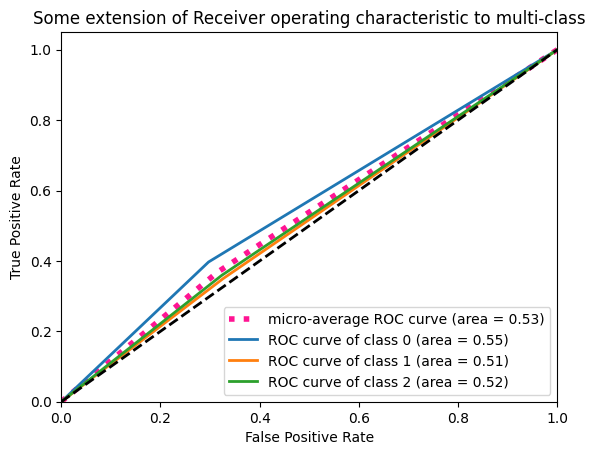

Recall: 0.3687
Precision: 0.3688
F1 Score: 0.3687
Top-1 Accuracy: 0.3687


In [11]:
# Binarize the output labels for ROC AUC since it's a multi-class setting
Yts_binarized = label_binarize(Yts, classes=np.unique(Yts))
y_test_pred_proba = model.predict_proba(Xts_flat)  # Make sure your model can output probabilities

# Compute the ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(Yts_binarized.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(Yts_binarized[:, i], y_test_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Yts_binarized.ravel(), y_test_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotting ROC curves
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

for i in range(Yts_binarized.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Evaluating other metrics
recall = recall_score(Yts, y_test_pred, average='macro')
precision = precision_score(Yts, y_test_pred, average='macro')
f1 = f1_score(Yts, y_test_pred, average='macro')
top1_accuracy = accuracy_score(Yts, y_test_pred)  # Top-1 Accuracy is the same as the normal accuracy

print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Top-1 Accuracy: {top1_accuracy:.4f}')

### CNN + Reweighting On 0.5 Dataset

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [6]:
dataset = np.load ('FashionMNIST0.5.npz')
#print(list(dataset.keys()))
Xtr_val = dataset['Xtr']
Str_val = dataset['Str']
Xts = dataset['Xts']
Yts = dataset['Yts']
#print(Xtr_val.shape)
#print(Str_val.shape)
#print(Xts.shape)
#print(Yts.shape)
# Normalize pixel values to the range [0, 1]
Xtr_val = Xtr_val / 255.0
Xts = Xts / 255.0

# Reshape input data to include the channel dimension (assuming grayscale images)
Xtr_val = Xtr_val.reshape(-1, 28, 28, 1)
Xts = Xts.reshape(-1, 28, 28, 1)

# One-hot encode labels
num_classes = 3
Str_val = keras.utils.to_categorical(Str_val, num_classes)
Yts = keras.utils.to_categorical(Yts, num_classes)

# Define a simplified ResNet model
def build_resnet(input_shape, num_classes):
    input_tensor = keras.Input(shape=input_shape)
    
    # Initial convolution layer
    x = layers.Conv2D(64, 7, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Residual blocks
    for _ in range(3):
        x = layers.Conv2D(64, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
    
    # Global average pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Fully connected layers
    x = layers.Dense(128, activation='relu')(x)
    output_tensor = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(input_tensor, output_tensor)
    return model

transition_matrix = np.array([[0.5, 0.2, 0.3],
                              [0.3, 0.5, 0.2],
                              [0.2, 0.3, 0.5]])

# Define a custom loss function that incorporates reweighting
def reweighted_categorical_crossentropy(transition_matrix):
    def loss(y_true, y_pred):
        # Compute the cross-entropy loss
        ce_loss = -tf.reduce_sum(y_true * tf.math.log(tf.clip_by_value(y_pred, 1e-10, 1.0)), axis=-1)

        # Apply reweighting using the transition matrix
        weighted_loss = tf.reduce_sum(ce_loss, axis=-1)
        reshaped_weights = tf.matmul(y_true, transition_matrix)
        weighted_loss = tf.reduce_sum(weighted_loss * reshaped_weights, axis=-1)

        return weighted_loss

    return loss

acc_valid_list = []
acc_test_without_T_list = []
acc_test_with_T_list = []
acc_valid_list = []
acc_test_list = []
for i in range(2):
    # Use the flattened data for splitting
    X_train, X_valid, y_train, y_valid = train_test_split(
        Xtr_val, Str_val, test_size=0.2, random_state=i
    )
    
    # Initialize the CostSensitiveDecisionTree with the cost matrix
    input_shape = X_train.shape[1:]
    model = build_resnet(input_shape, num_classes)
    model.compile(optimizer='adam', loss=reweighted_categorical_crossentropy(transition_matrix), metrics=['accuracy'])
    model.fit(Xtr_val, Str_val, batch_size=32, epochs=1, validation_split=0.2)
     # Evaluate the model on the validation set
    _, acc_valid = model.evaluate(X_valid, y_valid)
    acc_valid_list.append(acc_valid)
    
    # Evaluate the model on the test set
    _, acc_test = model.evaluate(Xts, Yts)
    acc_test_list.append(acc_test)

# Calculate the average performance over the 10 different splits
avg_valid_accuracy = np.mean(acc_valid_list)
avg_test_accuracy = np.mean(acc_test_list)

print(f"Average validation accuracy: {avg_valid_accuracy:.4f}")
print(f"Average test accuracy: {avg_test_accuracy:.4f}")

94/94 [==============================] - 7s 75ms/step - loss: 28.9787 - accuracy: 0.7207
Average validation accuracy: 0.4339
Average test accuracy: 0.6535


94/94 [==============================] - 7s 70ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.90      0.82      1000
           1       1.00      0.51      0.68      1000
           2       0.58      0.75      0.65      1000

    accuracy                           0.72      3000
   macro avg       0.78      0.72      0.72      3000
weighted avg       0.78      0.72      0.72      3000

Class 0 ROC-AUC: 0.9457
Class 1 ROC-AUC: 0.9300
Class 2 ROC-AUC: 0.7669


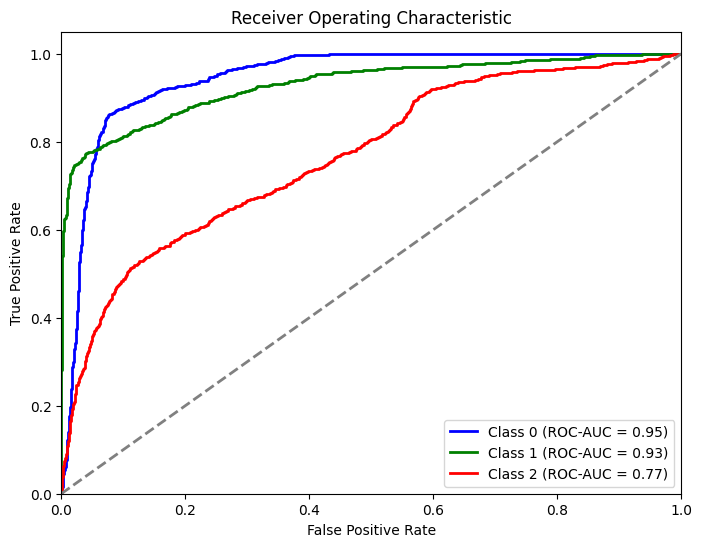

In [7]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict the probabilities for the test data
y_pred = model.predict(Xts)

# Convert one-hot encoded labels back to class labels
y_true = np.argmax(Yts, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute and print the classification report
report = classification_report(y_true, y_pred_classes, target_names=[str(i) for i in range(num_classes)])
print("Classification Report:\n", report)

# Compute and print ROC-AUC scores
roc_auc_scores = []
for i in range(num_classes):
    roc_auc = roc_auc_score(Yts[:, i], y_pred[:, i])
    roc_auc_scores.append(roc_auc)
    print(f"Class {i} ROC-AUC: {roc_auc:.4f}")

# Compute ROC curves and plot them
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Yts[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(Yts[:, i], y_pred[:, i])

# Plot ROC-AUC curves
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (ROC-AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [16]:
# Load the dataset
dataset = np.load('FashionMNIST0.5.npz')
Xtr_val = dataset['Xtr']
Str_val = dataset['Str']
Xts = dataset['Xts']
Yts = dataset['Yts']

# Data preprocessing
Xtr_val = Xtr_val / 255.0
Xts = Xts / 255.0
Xtr_val = Xtr_val.reshape(-1, 28, 28, 1)
Xts = Xts.reshape(-1, 28, 28, 1)
num_classes = 3
Str_val = keras.utils.to_categorical(Str_val, num_classes)
Yts = keras.utils.to_categorical(Yts, num_classes)

# Define a custom loss function with reweighting
def reweighted_categorical_crossentropy(transition_matrix):
    def loss(y_true, y_pred):
        ce_loss = -tf.reduce_sum(y_true * tf.math.log(tf.clip_by_value(y_pred, 1e-10, 1.0)), axis=-1)
        weighted_loss = tf.reduce_sum(ce_loss, axis=-1)
        reshaped_weights = tf.matmul(y_true, transition_matrix)
        weighted_loss = tf.reduce_sum(weighted_loss * reshaped_weights, axis=-1)
        return weighted_loss
    return loss

# Define a simplified ResNet model
def build_resnet(input_shape, num_classes):
    input_tensor = keras.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    for _ in range(3):
        x = layers.Conv2D(64, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    output_tensor = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(input_tensor, output_tensor)
    return model

transition_matrix = np.array([[0.5, 0.2, 0.3],
                              [0.3, 0.5, 0.2],
                              [0.2, 0.3, 0.5]])

# Define a function to perform the grid search and cross validation
def cross_validation(batch_size, num_epoch, n_splits=5):
    acc_valid_list = []
    acc_test_list = []
    
    kf = KFold(n_splits=n_splits)
    for train_index, valid_index in kf.split(Xtr_val):
        X_train, X_valid = Xtr_val[train_index], Xtr_val[valid_index]
        y_train, y_valid = Str_val[train_index], Str_val[valid_index]
        
        input_shape = X_train.shape[1:]
        model = build_resnet(input_shape, num_classes)
        model.compile(optimizer='adam', loss=reweighted_categorical_crossentropy(transition_matrix), metrics=['accuracy'])
        model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epoch, validation_data=(X_valid, y_valid))
        
        _, acc_valid = model.evaluate(X_valid, y_valid)
        acc_valid_list.append(acc_valid)
        _, acc_test = model.evaluate(Xts, Yts)
        acc_test_list.append(acc_test)
    
    avg_valid_accuracy = np.mean(acc_valid_list)
    avg_test_accuracy = np.mean(acc_test_list)
    
    print(f"Batch Size: {batch_size}, Epochs: {num_epoch}")
    print(f"Average validation accuracy: {avg_valid_accuracy:.4f}")
    print(f"Average test accuracy: {avg_test_accuracy:.4f}")
    
    return avg_valid_accuracy, avg_test_accuracy

# Perform cross validation with batch size and epochs
batch_sizes = [32, 64]
num_epochs = [2, 3]

for batch_size in batch_sizes:
    for num_epoch in num_epochs:
        avg_valid_accuracy, avg_test_accuracy = cross_validation(batch_size, num_epoch)

Epoch 1/2
450/450 [==============================] - 124s 274ms/step - loss: 34.2028 - accuracy: 0.4495 - val_loss: 33.6700 - val_accuracy: 0.4544
Epoch 2/2
94/94 [==============================] - 6s 69ms/step - loss: 31.0568 - accuracy: 0.5837
Epoch 1/2
450/450 [==============================] - 144s 316ms/step - loss: 34.0695 - accuracy: 0.4506 - val_loss: 34.9573 - val_accuracy: 0.3444
Epoch 2/2
94/94 [==============================] - 7s 71ms/step - loss: 28.0455 - accuracy: 0.8540
Epoch 1/2
450/450 [==============================] - 144s 318ms/step - loss: 34.0370 - accuracy: 0.4517 - val_loss: 36.0261 - val_accuracy: 0.3756
Epoch 2/2
94/94 [==============================] - 7s 71ms/step - loss: 25.9500 - accuracy: 0.8660
Epoch 1/2
450/450 [==============================] - 149s 326ms/step - loss: 34.1642 - accuracy: 0.4409 - val_loss: 34.0855 - val_accuracy: 0.4447
Epoch 2/2
94/94 [==============================] - 7s 69ms/step - loss: 30.3747 - accuracy: 0.7107
Epoch 1/2
450/45

### CNN + Reweighting On 0.6 Dataset

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [19]:
dataset = np.load ('FashionMNIST0.6.npz')
#print(list(dataset.keys()))
Xtr_val = dataset['Xtr']
Str_val = dataset['Str']
Xts = dataset['Xts']
Yts = dataset['Yts']
#print(Xtr_val.shape)
#print(Str_val.shape)
#print(Xts.shape)
#print(Yts.shape)
# Normalize pixel values to the range [0, 1]
Xtr_val = Xtr_val / 255.0
Xts = Xts / 255.0

# Reshape input data to include the channel dimension (assuming grayscale images)
Xtr_val = Xtr_val.reshape(-1, 28, 28, 1)
Xts = Xts.reshape(-1, 28, 28, 1)

# One-hot encode labels
num_classes = 3
Str_val = keras.utils.to_categorical(Str_val, num_classes)
Yts = keras.utils.to_categorical(Yts, num_classes)

# Define a simplified ResNet model
def build_resnet(input_shape, num_classes):
    input_tensor = keras.Input(shape=input_shape)
    
    # Initial convolution layer
    x = layers.Conv2D(64, 7, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Residual blocks
    for _ in range(3):
        x = layers.Conv2D(64, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
    
    # Global average pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Fully connected layers
    x = layers.Dense(128, activation='relu')(x)
    output_tensor = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(input_tensor, output_tensor)
    return model

transition_matrix = np.array([[0.4, 0.3, 0.3],
                              [0.3, 0.4, 0.3],
                              [0.3, 0.3, 0.4]])

# Define a function to perform the grid search and cross validation
def cross_validation(batch_size, num_epoch, n_splits=2):
    acc_valid_list = []
    acc_test_list = []
    
    kf = KFold(n_splits=n_splits)
    for train_index, valid_index in kf.split(Xtr_val):
        X_train, X_valid = Xtr_val[train_index], Xtr_val[valid_index]
        y_train, y_valid = Str_val[train_index], Str_val[valid_index]
        
        input_shape = X_train.shape[1:]
        model = build_resnet(input_shape, num_classes)
        model.compile(optimizer='adam', loss=reweighted_categorical_crossentropy(transition_matrix), metrics=['accuracy'])
        model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epoch, validation_data=(X_valid, y_valid))
        
        _, acc_valid = model.evaluate(X_valid, y_valid)
        acc_valid_list.append(acc_valid)
        _, acc_test = model.evaluate(Xts, Yts)
        acc_test_list.append(acc_test)
    
    avg_valid_accuracy = np.mean(acc_valid_list)
    avg_test_accuracy = np.mean(acc_test_list)
    
    print(f"Batch Size: {batch_size}, Epochs: {num_epoch}")
    print(f"Average validation accuracy: {avg_valid_accuracy:.4f}")
    print(f"Average test accuracy: {avg_test_accuracy:.4f}")
    
    return avg_valid_accuracy, avg_test_accuracy

# Perform cross validation with batch size and epochs
batch_sizes = [32, 64]
num_epochs = [2, 3]

for batch_size in batch_sizes:
    for num_epoch in num_epochs:
        avg_valid_accuracy, avg_test_accuracy = cross_validation(batch_size, num_epoch)

Epoch 1/2
282/282 [==============================] - 49s 172ms/step - loss: 35.3026 - accuracy: 0.3567 - val_loss: 35.1855 - val_accuracy: 0.3477
Epoch 2/2
94/94 [==============================] - 3s 32ms/step - loss: 31.8470 - accuracy: 0.6857
Epoch 1/2
282/282 [==============================] - 51s 179ms/step - loss: 35.2495 - accuracy: 0.3512 - val_loss: 35.2526 - val_accuracy: 0.3323
Epoch 2/2
94/94 [==============================] - 3s 33ms/step - loss: 30.1192 - accuracy: 0.6167
Batch Size: 32, Epochs: 2
Average validation accuracy: 0.3670
Average test accuracy: 0.6512
Epoch 1/3
282/282 [==============================] - 57s 199ms/step - loss: 35.2659 - accuracy: 0.3552 - val_loss: 35.4866 - val_accuracy: 0.3360
Epoch 2/3
282/282 [==============================] - 55s 194ms/step - loss: 35.0991 - accuracy: 0.3684 - val_loss: 35.0424 - val_accuracy: 0.3667
Epoch 3/3
94/94 [==============================] - 3s 35ms/step - loss: 33.3198 - accuracy: 0.6130
Epoch 1/3
282/282 [========

94/94 [==============================] - 3s 32ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.90      0.82      1000
           1       1.00      0.51      0.68      1000
           2       0.58      0.75      0.65      1000

    accuracy                           0.72      3000
   macro avg       0.78      0.72      0.72      3000
weighted avg       0.78      0.72      0.72      3000

Class 0 ROC-AUC: 0.9457
Class 1 ROC-AUC: 0.9300
Class 2 ROC-AUC: 0.7669


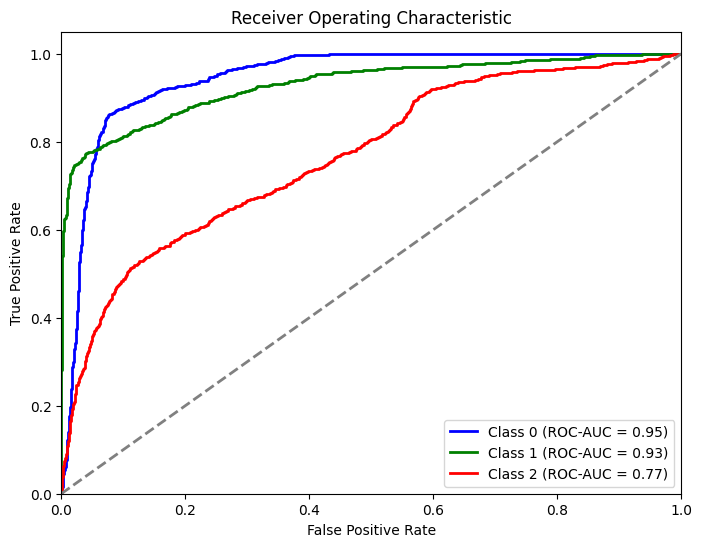

In [20]:
# Predict the probabilities for the test data
y_pred = model.predict(Xts)

# Convert one-hot encoded labels back to class labels
y_true = np.argmax(Yts, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute and print the classification report
report = classification_report(y_true, y_pred_classes, target_names=[str(i) for i in range(num_classes)])
print("Classification Report:\n", report)

# Compute and print ROC-AUC scores
roc_auc_scores = []
for i in range(num_classes):
    roc_auc = roc_auc_score(Yts[:, i], y_pred[:, i])
    roc_auc_scores.append(roc_auc)
    print(f"Class {i} ROC-AUC: {roc_auc:.4f}")

# Compute ROC curves and plot them
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Yts[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(Yts[:, i], y_pred[:, i])

# Plot ROC-AUC curves
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (ROC-AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [21]:
# Load the dataset
dataset = np.load('FashionMNIST0.5.npz')
Xtr_val = dataset['Xtr']
Str_val = dataset['Str']
Xts = dataset['Xts']
Yts = dataset['Yts']

# Data preprocessing
Xtr_val = Xtr_val / 255.0
Xts = Xts / 255.0
Xtr_val = Xtr_val.reshape(-1, 28, 28, 1)
Xts = Xts.reshape(-1, 28, 28, 1)
num_classes = 3
Str_val = keras.utils.to_categorical(Str_val, num_classes)
Yts = keras.utils.to_categorical(Yts, num_classes)

# Define a custom loss function with reweighting
def reweighted_categorical_crossentropy(transition_matrix):
    def loss(y_true, y_pred):
        ce_loss = -tf.reduce_sum(y_true * tf.math.log(tf.clip_by_value(y_pred, 1e-10, 1.0)), axis=-1)
        weighted_loss = tf.reduce_sum(ce_loss, axis=-1)
        reshaped_weights = tf.matmul(y_true, transition_matrix)
        weighted_loss = tf.reduce_sum(weighted_loss * reshaped_weights, axis=-1)
        return weighted_loss
    return loss

# Define a simplified ResNet model
def build_resnet(input_shape, num_classes):
    input_tensor = keras.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    for _ in range(3):
        x = layers.Conv2D(64, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    output_tensor = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(input_tensor, output_tensor)
    return model

transition_matrix = np.array([[0.5, 0.2, 0.3],
                              [0.3, 0.5, 0.2],
                              [0.2, 0.3, 0.5]])

# Define a function to perform the grid search and cross validation
def cross_validation(batch_size, num_epoch, n_splits=2):
    acc_valid_list = []
    acc_test_list = []
    
    kf = KFold(n_splits=n_splits)
    for train_index, valid_index in kf.split(Xtr_val):
        X_train, X_valid = Xtr_val[train_index], Xtr_val[valid_index]
        y_train, y_valid = Str_val[train_index], Str_val[valid_index]
        
        input_shape = X_train.shape[1:]
        model = build_resnet(input_shape, num_classes)
        model.compile(optimizer='adam', loss=reweighted_categorical_crossentropy(transition_matrix), metrics=['accuracy'])
        model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epoch, validation_data=(X_valid, y_valid))
        
        _, acc_valid = model.evaluate(X_valid, y_valid)
        acc_valid_list.append(acc_valid)
        _, acc_test = model.evaluate(Xts, Yts)
        acc_test_list.append(acc_test)
    
    avg_valid_accuracy = np.mean(acc_valid_list)
    avg_test_accuracy = np.mean(acc_test_list)
    
    print(f"Batch Size: {batch_size}, Epochs: {num_epoch}")
    print(f"Average validation accuracy: {avg_valid_accuracy:.4f}")
    print(f"Average test accuracy: {avg_test_accuracy:.4f}")
    
    return avg_valid_accuracy, avg_test_accuracy

# Perform cross validation with batch size and epochs
batch_sizes = [32, 64]
num_epochs = [2, 3]

for batch_size in batch_sizes:
    for num_epoch in num_epochs:
        avg_valid_accuracy, avg_test_accuracy = cross_validation(batch_size, num_epoch)

Epoch 1/2
282/282 [==============================] - 51s 179ms/step - loss: 34.2254 - accuracy: 0.4483 - val_loss: 38.6103 - val_accuracy: 0.3268
Epoch 2/2
94/94 [==============================] - 3s 30ms/step - loss: 27.6235 - accuracy: 0.7747
Epoch 1/2
282/282 [==============================] - 54s 189ms/step - loss: 34.1642 - accuracy: 0.4446 - val_loss: 37.0851 - val_accuracy: 0.3757
Epoch 2/2
94/94 [==============================] - 3s 31ms/step - loss: 27.0680 - accuracy: 0.6540
Batch Size: 32, Epochs: 2
Average validation accuracy: 0.4251
Average test accuracy: 0.7143
Epoch 1/3
282/282 [==============================] - 58s 201ms/step - loss: 34.2055 - accuracy: 0.4389 - val_loss: 37.4436 - val_accuracy: 0.3269
Epoch 2/3
282/282 [==============================] - 55s 196ms/step - loss: 33.8544 - accuracy: 0.4609 - val_loss: 34.6054 - val_accuracy: 0.4270
Epoch 3/3
94/94 [==============================] - 3s 35ms/step - loss: 32.1401 - accuracy: 0.4130
Epoch 1/3
282/282 [========

### CNN + Reweighting On CIFAR Dataset

In [22]:
# Load the CIFAR dataset
cifar_data = np.load('CIFAR.npz', allow_pickle=True)
Xtr_val, Str, Xts, Yts = cifar_data['Xtr'], cifar_data['Str'], cifar_data['Xts'], cifar_data['Yts']
#print("Xtr_val shape:", Xtr_val.shape)
#print("Str shape:", Str.shape)
# Define a simplified ResNet model
def build_resnet(input_shape, num_classes):
    input_tensor = keras.Input(shape=input_shape)
    
    # Initial convolution layer
    x = layers.Conv2D(64, 7, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Residual blocks
    for _ in range(3):
        x = layers.Conv2D(64, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
    
    # Global average pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Fully connected layers
    x = layers.Dense(128, activation='relu')(x)
    output_tensor = layers.Dense(num_classes, activation='softmax')(x)  # Ensure num_classes units
    
    model = keras.Model(input_tensor, output_tensor)
    return model

def reweighted_categorical_crossentropy(transition_matrix):
    def loss(y_true, y_pred):
        # Ensure y_true is of integer type and flatten it
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.reshape(y_true, [-1])

        # Verify the number of classes
        num_classes = tf.shape(transition_matrix)[0]

        # One-hot encode y_true
        y_true_one_hot = tf.one_hot(y_true, depth=num_classes)

        # Check the shapes of your tensors
        #print("Shape of y_true_one_hot:", tf.shape(y_true_one_hot))
        #print("Shape of y_pred:", tf.shape(y_pred))

        # Compute the cross-entropy loss
        ce_loss = -tf.reduce_sum(y_true_one_hot * tf.math.log(tf.clip_by_value(y_pred, 1e-10, 1.0)), axis=-1)

        # Apply reweighting using the transition matrix
        weighted_loss = tf.reduce_sum(ce_loss, axis=-1)
        reshaped_weights = tf.matmul(y_true_one_hot, transition_matrix)
        weighted_loss = tf.reduce_sum(weighted_loss * reshaped_weights, axis=-1)

        return weighted_loss

    return loss
def estimate_transition_matrix(labels):
    num_classes = np.max(labels) + 1
    transition_matrix = np.zeros((num_classes, num_classes))

    for i in range(len(labels) - 1):
        transition_matrix[labels[i], labels[i+1]] += 1

    # Normalize the transition matrix
    row_sums = transition_matrix.sum(axis=1)
    transition_matrix = transition_matrix / row_sums[:, np.newaxis]

    return transition_matrix

# Variables to store results
acc_valid_list = []
acc_test_list = []
estimated_transition_matrices = []

for i in range(2):
    # Use the flattened data for splitting
    X_train, X_valid, y_train, y_valid = train_test_split(
        Xtr_val, Str, test_size=0.2, random_state=i
    )
    #print("Shape of X_train:", X_train.shape)
    #print("Shape of y_train:", y_train.shape)
    #print("Shape of X_valid:", X_valid.shape)
    #print("Shape of y_valid:", y_valid.shape)
    # Initialize the CostSensitiveDecisionTree with the cost matrix
    input_shape = X_train.shape[1:]
    num_classes = np.max(y_train) + 1
    #print("Number of classes:", num_classes)
    model = build_resnet(input_shape, num_classes)
    
    # Estimate the transition matrix
    #print("entering estimations")
    estimated_transition_matrix = estimate_transition_matrix(y_train)
    estimated_transition_matrices.append(estimated_transition_matrix)
    
    model.compile(optimizer='adam', loss=reweighted_categorical_crossentropy(estimated_transition_matrix), metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=32, epochs=2, validation_data=(X_valid, y_valid))
    
    # Evaluate the model on the validation set
    _, acc_valid = model.evaluate(X_valid, y_valid)
    acc_valid_list.append(acc_valid)
    
    # Evaluate the model on the test set
    _, acc_test = model.evaluate(Xts, Yts)
    acc_test_list.append(acc_test)

# Calculate the average performance over the 10 different splits
avg_valid_accuracy = np.mean(acc_valid_list)
avg_test_accuracy = np.mean(acc_test_list)

print(f"Average validation accuracy: {avg_valid_accuracy:.4f}")
print(f"Average test accuracy: {avg_test_accuracy:.4f}")

# Output the final estimated transition matrix
avg_transition_matrix = np.mean(estimated_transition_matrices, axis=0)
print("Estimated Transition Matrix:")
print(avg_transition_matrix)

Epoch 1/2
375/375 [==============================] - 102s 270ms/step - loss: 35.3027 - accuracy: 0.3476 - val_loss: 35.3072 - val_accuracy: 0.3407
Epoch 2/2
94/94 [==============================] - 5s 55ms/step - loss: 34.2327 - accuracy: 0.4860
Epoch 1/2
375/375 [==============================] - 87s 230ms/step - loss: 35.3419 - accuracy: 0.3501 - val_loss: 35.2857 - val_accuracy: 0.3520
Epoch 2/2
94/94 [==============================] - 5s 55ms/step - loss: 34.1774 - accuracy: 0.3930
Average validation accuracy: 0.3505
Average test accuracy: 0.4395
Estimated Transition Matrix:
[[0.32982026 0.33246028 0.33771946]
 [0.33150333 0.33262421 0.33587246]
 [0.33838542 0.3363945  0.32522009]]


94/94 [==============================] - 5s 56ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.01      0.03      1000
           1       0.35      0.96      0.52      1000
           2       0.77      0.21      0.33      1000

    accuracy                           0.39      3000
   macro avg       0.56      0.39      0.29      3000
weighted avg       0.56      0.39      0.29      3000

Class 0 ROC-AUC: 0.7624
Class 1 ROC-AUC: 0.6743
Class 2 ROC-AUC: 0.7061


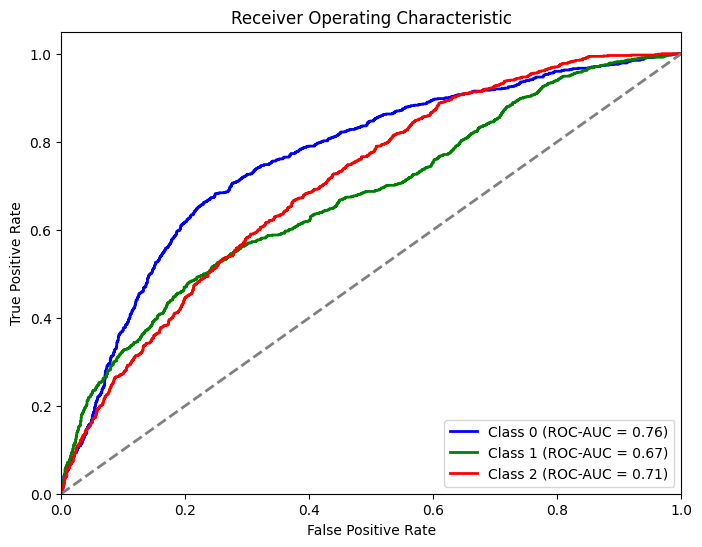

In [23]:
from sklearn.metrics import roc_curve, auc
# Predict the probabilities for the test data
y_pred = model.predict(Xts)

# Convert one-hot encoded labels back to class labels
y_true = np.argmax(Yts, axis=None)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = Yts
num_classes = len(np.unique(Yts))
y_pred_classes = np.argmax(y_pred, axis=1)
unique_labels_true = np.unique(y_true)
unique_labels_pred = np.unique(y_pred_classes)

# Compute and print the classification report
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred_classes, target_names=[str(i) for i in range(num_classes)])
print("Classification Report:\n", report)

# Compute and print ROC-AUC scores
roc_auc_scores = []
for i in range(num_classes):
    roc_auc = roc_auc_score((Yts == i).astype(int), y_pred[:, i])
    roc_auc_scores.append(roc_auc)
    print(f"Class {i} ROC-AUC: {roc_auc:.4f}")

# Compute ROC curves and plot them
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((Yts == i).astype(int), y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC-AUC curves
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (ROC-AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show() 

In [24]:
# Load the CIFAR dataset
cifar_data = np.load('CIFAR.npz', allow_pickle=True)
Xtr_val, Str, Xts, Yts = cifar_data['Xtr'], cifar_data['Str'], cifar_data['Xts'], cifar_data['Yts']

# Define a simplified ResNet model
def build_resnet(input_shape, num_classes):
    input_tensor = keras.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    for _ in range(3):
        x = layers.Conv2D(64, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    output_tensor = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(input_tensor, output_tensor)
    return model

# Define a custom loss function with reweighting
def reweighted_categorical_crossentropy(transition_matrix):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.reshape(y_true, [-1])
        num_classes = tf.shape(transition_matrix)[0]
        y_true_one_hot = tf.one_hot(y_true, depth=num_classes)
        ce_loss = -tf.reduce_sum(y_true_one_hot * tf.math.log(tf.clip_by_value(y_pred, 1e-10, 1.0)), axis=-1)
        weighted_loss = tf.reduce_sum(ce_loss, axis=-1)
        reshaped_weights = tf.matmul(y_true_one_hot, transition_matrix)
        weighted_loss = tf.reduce_sum(weighted_loss * reshaped_weights, axis=-1)
        return weighted_loss
    return loss

# Define a function to perform the grid search and cross validation
def cross_validation(batch_size, num_epoch, n_splits=2):
    acc_valid_list = []
    acc_test_list = []
    estimated_transition_matrices_list = []
    
    kf = KFold(n_splits=n_splits)
    for train_index, valid_index in kf.split(Xtr_val):
        X_train, X_valid = Xtr_val[train_index], Xtr_val[valid_index]
        y_train, y_valid = Str[train_index], Str[valid_index]
        
        input_shape = X_train.shape[1:]
        num_classes = np.max(y_train) + 1
        model = build_resnet(input_shape, num_classes)
        estimated_transition_matrix = estimate_transition_matrix(y_train)
        estimated_transition_matrices_list.append(estimated_transition_matrix)
        model.compile(optimizer='adam', loss=reweighted_categorical_crossentropy(estimated_transition_matrix), metrics=['accuracy'])
        model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epoch, validation_data=(X_valid, y_valid))
        
        _, acc_valid = model.evaluate(X_valid, y_valid)
        acc_valid_list.append(acc_valid)
        _, acc_test = model.evaluate(Xts, Yts)
        acc_test_list.append(acc_test)
    
    avg_valid_accuracy = np.mean(acc_valid_list)
    avg_test_accuracy = np.mean(acc_test_list)
    
    print(f"Batch Size: {batch_size}, Epochs: {num_epoch}")
    print(f"Average validation accuracy: {avg_valid_accuracy:.4f}")
    print(f"Average test accuracy: {avg_test_accuracy:.4f}")
    print("Estimated Transition Matrix:")
    print(np.mean(estimated_transition_matrices_list, axis=0))
    
    return avg_valid_accuracy, avg_test_accuracy, estimated_transition_matrices_list

# Perform cross validation with batch size and epochs
batch_sizes = [32, 64]
num_epochs = [2, 3]

for batch_size in batch_sizes:
    for num_epoch in num_epochs:
        avg_valid_accuracy, avg_test_accuracy, estimated_transition_matrices_list = cross_validation(batch_size, num_epoch)

Epoch 1/2
235/235 [==============================] - 65s 271ms/step - loss: 35.3412 - accuracy: 0.3497 - val_loss: 35.8887 - val_accuracy: 0.3467
Epoch 2/2
94/94 [==============================] - 5s 51ms/step - loss: 34.6430 - accuracy: 0.3930
Epoch 1/2
235/235 [==============================] - 61s 257ms/step - loss: 35.3400 - accuracy: 0.3416 - val_loss: 37.5718 - val_accuracy: 0.3411
Epoch 2/2
94/94 [==============================] - 5s 51ms/step - loss: 32.6936 - accuracy: 0.4997
Batch Size: 32, Epochs: 2
Average validation accuracy: 0.3415
Average test accuracy: 0.4463
Estimated Transition Matrix:
[[0.33053351 0.33797969 0.3314868 ]
 [0.33227845 0.33365653 0.33406502]
 [0.33746626 0.32822542 0.33430833]]
Epoch 1/3
235/235 [==============================] - 60s 252ms/step - loss: 35.3897 - accuracy: 0.3429 - val_loss: 35.4950 - val_accuracy: 0.3475
Epoch 2/3
235/235 [==============================] - 59s 250ms/step - loss: 35.1932 - accuracy: 0.3540 - val_loss: 35.3998 - val_accur